In [21]:
%matplotlib notebook
import numpy as np
from modsim import *
import math
import numpy as np

# 125 meters in between each building in distance, 11 meters in height

In [22]:
#################################################### FRISBEE SYSTEM ############################################################
def make_frisbee_system(v, alpha, duration):
    """
    Makes a frisbee object, but really it's a System object with a state object.
    x = Inital x coordinate of the disk.
    y = Inital y coordinate of the disk.
    vx = Inital x velocity of the disk.
    vy = Initial y velocity of the disk.
    alpha = Angle of the disk being thrown
    
    Returns a system object with all of the good stuff needed for the slope function and all of that.
    """
    x= 0
    y = 0
    vx = abs(v*math.cos(alpha))
    vy = abs(v*math.sin(alpha))

    init = State(x=x, y=y, vx=vx, vy=vy)
    g = 9.8 #* UNITS.meter / UNITS.second**2
    m = .175 #* UNITS.kilogram # Mass of frisbee
    rho = 1.23  #* UNITS.kilogram/UNITS.meter**3 # Density of air
    area = 0.0568 #* UNITS.meter**2 # Surface area of frisbee
    CL0 = 0.6 # Lift coefficient alpha=0.
    CLA = 1.4 # Alpha-dependent lift coefficient
    # Drag coefficient when alpha = 0
    CD0 = 0.08
    # Alpha-dependent drag coefficient
    CDA = 2.78
    # Constant associated with launch angle.
    alpha_constant = 4.0
    # Launch angle (in degrees).
    alpha = alpha

    # Now that we have lots of constants, we can calculate the actual coefficients.
    # Lift coefficient.
    CL = CL0 + CLA*(alpha-alpha_constant)*math.pi/180
    # Drag coefficient.
    CD = CD0 + CDA*((alpha - alpha_constant) * math.pi/180)**2
    # print(CD)
    # Array of times around which this should be created.
    ts = linspace(0, duration)
    # Return our system, because real object oriented programming is "soooo overrated"
    return System(init=init, g=g, m=m, rho=rho, area=area, CL=CL, CD=CD, ts=ts)




def frisbee_slope_func(state, t, system):
    """
    Makes the frisbee fly, I guess...
    """
    x, y, vx, vy = state
    unpack(system)

    # Make some useful vectors.
    a_grav = Vector(0, -g)
    # v = Vector(vx, vy)
    # Make some change vectors.
    ax = (rho*(vx**2)*area*CD)/2*m
    ay = (((rho*(vy**2)*area*(CL))/2) - 9.8)/m
    
    return vx, vy, ax, ay



In [23]:
#################################################### PENDULUM SYSTEM ############################################################
def make_pendulum_system():
    """
    Makes a frisbee object, but really it's a System object with a state object.

        
    returns: System with init, g, m, rho, C_d, area, and ts
    """
    g = 9.8
    m = .10
    area = .3871
    rho = 1.23
    v_term = 60
    duration = 30
    length0 = 1
    angle = (270 - 45)
    k = 40
    theta = np.deg2rad(angle)
    x, y = pol2cart(theta, length0)
    P = Vector(x, y)
    V = Vector(0, 0)
    
    init = State(x=P.x, y=P.y, vx=V.x, vy=V.y)
    mg = m*g
    C_d = (2*mg)/(rho*area*(v_term**2))
    ts = linspace(0, duration, 501)
    
    return System(init=init, g=g, m=m, rho=rho,
                  C_d=C_d, area=area, length0=length0,
                  k=k, ts=ts)

def pendulum_slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with length0, m, k
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    ax = k*length0*x/(m*sqrt(x**2 + y**2)) - k*x/m
    ay = -g + k*length0*y/(m*sqrt(x**2 + y**2)) - k*y/m

    return vx, vy, ax, ay

0.000000      0.000000e+00
0.408163      1.037920e+02
0.816327      2.392707e+06
1.224490     5.603840e+179
1.632653      5.702511e+15
2.040816      1.279467e+07
2.448980      1.138529e+93
2.857143      1.482857e+11
3.265306    -5.027206e-311
3.673469     1.102886e+252
4.081633      2.646240e+93
4.489796     4.042616e+233
4.897959      1.306566e+36
5.306122     1.024940e+190
5.714286      1.350167e-66
6.122449     4.888552e+257
6.530612      4.275258e+50
6.938776     9.736150e+280
7.346939      1.010783e+07
7.755102     2.781206e-100
8.163265     8.852999e+246
8.571429     3.031914e+233
8.979592    -6.143376e-311
9.387755     1.951915e+267
9.795918     1.760301e+223
10.204082     1.534765e+59
10.612245     8.056828e+35
11.020408     2.794219e+06
11.428571     2.261635e+06
11.836735    9.596589e+227
12.244898    8.507889e+194
12.653061     3.836513e+06
13.061224     1.138529e+93
13.469388    5.362060e+189
13.877551     3.535107e+54
14.285714     3.455609e-66
14.693878     4.361018e+11
1

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


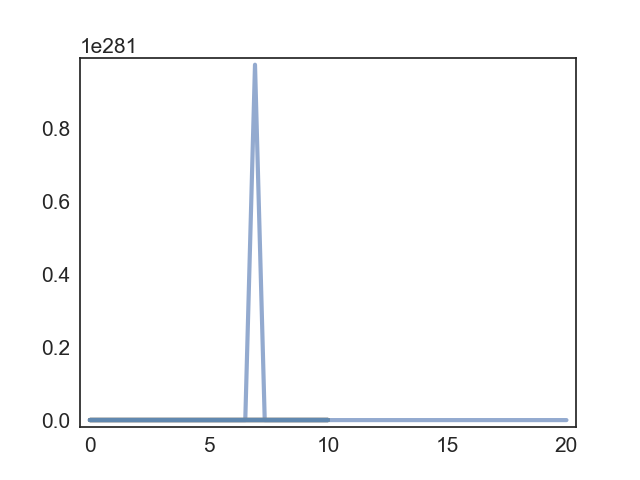

In [24]:
# Frisbee system more like... frisbee system
frisbee = make_frisbee_system(30, 20, 20)
run_odeint(frisbee, frisbee_slope_func)
print(frisbee.results.y)
plot(frisbee.results.y)

In [25]:
# Wow! The pendulum system!
system = make_pendulum_system()
run_odeint(system, pendulum_slope_func)
(system.results.x)

0.00    -0.707107
0.06    -0.706100
0.12    -0.693223
0.18    -0.651690
0.24    -0.578477
0.30    -0.485241
0.36    -0.380998
0.42    -0.263616
0.48    -0.130456
0.54     0.012122
0.60     0.154598
0.66     0.291858
0.72     0.418117
0.78     0.521505
0.84     0.593989
0.90     0.642967
0.96     0.683222
1.02     0.717128
1.08     0.730928
1.14     0.713410
1.20     0.671006
1.26     0.618246
1.32     0.557541
1.38     0.476993
1.44     0.367941
1.50     0.236233
1.56     0.093897
1.62    -0.051608
1.68    -0.194005
1.74    -0.322950
           ...   
28.26   -0.018986
28.32    0.127022
28.38    0.267786
28.44    0.392822
28.50    0.492156
28.56    0.568033
28.62    0.632029
28.68    0.687478
28.74    0.722610
28.80    0.726382
28.86    0.704864
28.92    0.674075
28.98    0.638552
29.04    0.585382
29.10    0.501416
29.16    0.389081
29.22    0.260742
29.28    0.124243
29.34   -0.017513
29.40   -0.157720
29.46   -0.287335
29.52   -0.404118
29.58   -0.510345
29.64   -0.600640
29.70   -0

In [31]:
# Now, let's think about combining models together... It'll be great!!!!!!!!!!

def combine_models(velocity, angle, duration):
    """
    Combines frisbee and pendulum models to describe a system where a frisbee flies through the air
    from (0, 0)
    """    
    frisbee = make_frisbee_system(velocity, angle, duration)
    run_odeint(frisbee, frisbee_slope_func)
    time_series = linrange(0, duration)   
    
    fx = interpolate(frisbee.results.x)
    i_fx = fx(time_series)
    fy = interpolate(frisbee.results.y)
    i_fy = fy(time_series)
    
    pendulum = make_pendulum_system()
    run_odeint(pendulum, pendulum_slope_func)
    px = interpolate(pendulum.results.x)
    i_px = px(time_series)
    py = interpolate(pendulum.results.y)
    i_py = py(time_series)  
    
    x_combined = np.add(i_fx, i_px)
    plot(time_series, x_combined)
    y_combined = np.add(i_fy, i_py)
    plot(time_series, y_combined) 
   # plot(x_combined, y_combined)
    
    
    
combine_models(30, 10, 10)
          
    